In [1]:
# Required Libraries
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as sts
import random as random

In [2]:
class TrafficSimulation:
    def __init__(self, road_length = 100, car_density = 0.2, prob_slow = 0.5, max_speed = 5):
        
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        # Create an empty road, use -1 for an empty road
        self.state = np.full(self.road_length, -1, dtype=int)
        
        # Use numpy random operation to obtain random number for location of cars
        random_indexes = np.random.choice(range(self.road_length),
                                          size=int(round(car_density * self.road_length)),
                                          replace=False)
        
        # Assign a random initial speed
        self.state[random_indexes] = np.random.randint(0, self.max_speed + 1, size=len(random_indexes))

        # Keep count of the time steps with a counter for each step
        self.time_step = 0
        
        # Keep track of average traffic flow for each step of the simulation
        self.average_traffic_flow = []

    def updateSimulation(self, optimized = True):
        
        """
        Advance one time step in the simulation.
        """

        if optimized:
            return self.updateSimulationoptimized()
        
        # Update car speeds by iterating through the length of the road
        for i in range(self.road_length):
            if self.state[i] != -1:
                distance = 1
        
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                    
                # accelerate
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                    
                # delerates
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                    
                # check whether to slow down or not
                if ((self.state[i] > 0) and (np.random.uniform() < self.prob_slow)):
                    self.state[i] -= 1

        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                # move car
                new_state[(i + cell) % self.road_length] = cell

        # Update 
        self.state = new_state
        
        self.time_step += 1
        self.average_traffic_flow.append(sum(self.state[self.state > 0]) / self.road_length)

    def updateSimulationoptimized(self):
        
        """
        Advance one time step in the simulation using a optimized method from before.
        """
        
        # obtain the location 
        car_location = np.where(self.state >= 0)[0]
        
        if len(car_location) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # current speed and location
        car_speed = self.state[car_location]
        
        car_distance = np.ediff1d(np.concatenate((car_location,
                                                  [car_location[0] + self.road_length])))
        
        # acceleration
        car_speed = np.where(car_speed + 1 <= self.max_speed, car_speed + 1, self.max_speed)
        
        # decleration
        car_speed = np.where(car_speed >= car_distance, car_distance - 1, car_speed)        
        moving_car_location = np.where(car_speed > 0)[0]      
        car_speed[moving_car_location] -= (np.random.uniform(
            size = len(moving_car_location)) < self.prob_slow)

        # cars moving forward
        car_location += car_speed
        car_location %= self.road_length
        self.state.fill(-1)
        self.state[car_location] = car_speed

        self.time_step += 1       
        self.average_traffic_flow.append(sum(car_speed) / self.road_length)


    def displayState(self):
        
        """
        Print out the current state of the simulation.
        """
        
        print(''.join('.' if x == -1 else str(x) for x in self.state))

In [3]:
trials = 200 # total sims
densities = np.linspace(0, 1, 101) # traffic densities
average_flow = []  #

for density in densities:
    traffic_flow = []
    
    for trial in range(trials):
        sim = TrafficSimulation(road_length = 100, 
                                car_density = density, 
                                max_speed = 5, 
                                prob_slow = 0.5)
        
        # Run steps to reach an equilibrium state
        for step in range(50):
            sim.updateSimulation()
        
        # Record the final average traffic flow
        traffic_flow.append(sim.average_traffic_flow[-1])
        
    average_flow.append(traffic_flow)
    
average_flow = np.array(average_flow)

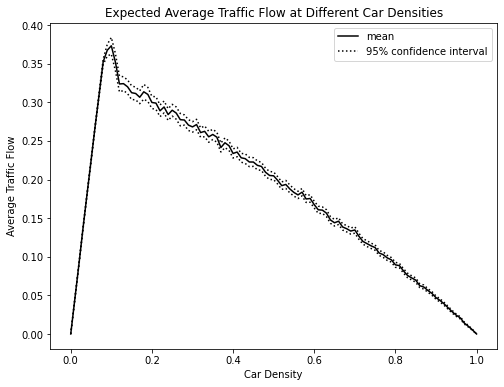

In [4]:
plt.figure(figsize = (8, 6))
plt.title('Expected Average Traffic Flow at Different Car Densities')
plt.xlabel('Car Density')
plt.ylabel('Average Traffic Flow')
flow_mean = np.mean(average_flow, axis=1)
std_err = sts.sem(average_flow, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:', label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()

# Intersection Model

In [26]:
class StreetSimulation:
    def __init__(self, road_length, car_density = 0.2, 
                 prob_slow = 0.5, max_speed = 5, lanes = 1, 
                 traffic_lights_positions = [100]):
        
        """
        road length : total length of road
        car_density : amount of cars on the road
        prob_slow : probability of slowing down
        max_speed : Max speed allowed
        lanes : total number of lanes
        traffic_lights_positions : at what point is the traffic light
        """
         
        self.road_length = road_length 
        self.car_density = car_density
        self.prob_slow = prob_slow
        self.max_speed = max_speed
        self.lanes = lanes
        self.traffic_lights_positions = traffic_lights_positions
        self.lanes_state = []
        
        # traffic light timer
        self.light_timer = 30
        
        # Traffic light status
        self.traffic_red = {}
        
        # tracking switch
        self.light_switch = {}
        
        # Track the average traffic flow per lane
        self.average_traffic_flow = {}
        
        # The average traffic flow among all the lanes
        self.final_average_traffic_flow = []
        
        # initialise with all green lights
        for traffic_light in self.traffic_lights_positions:
            self.light_switch[traffic_light] = [False] * self.lanes
            self.traffic_red [traffic_light] = False

        # for each lane
        for lane in range(lanes):
            
            self.state = None
            # empty road
            self.state = np.full(self.road_length, -1, dtype=int)
            # random location
            random_indexes = np.random.choice(range(self.road_length),
                                               size = int(round(car_density * self.road_length)),
                                               replace = False)
            # random init speed (slower than usual) so cars are not extremely fast while light just turned
            self.state[random_indexes] = np.random.randint(0, 3, 
                                                            size = len(random_indexes))
            self.lanes_state.append(self.state)
            self.average_traffic_flow[lane] = []
        self.time_step = 0  
        
    def traffic_light_switch(self, current_traffic, position):
        
        """
        Switching the traffic light
        """
        
        # Change the determined traffic light to the given state
        self.traffic_red[position] = current_traffic
        self.light_switch[position] = [True]*self.lanes


    def updateSimulation(self):
        
        """
        Progress of 1 time step and then update
        """
        # complete flow of the street
        total_flow = 0
        for lane_no, state in enumerate(self.lanes_state):
            start_point = 0

            # for every position in the road
            for index in range(len(self.traffic_lights_positions) + 1):       
                # boundary condition
                if index < len(self.traffic_lights_positions): 
                    
                    # Traffic light position
                    light = self.traffic_lights_positions[index]     
                    # In the case of a red light
                    if self.traffic_red[light]: 
                        self.lanes_state[lane_no][light] = 0
                    # in the case that it is ready to switch
                    elif self.lanes_state[lane_no][light] == 0 and self.light_switch[light][lane_no]:
                        
                        # switch to green
                        self.lanes_state[lane_no][light] = -1
                        
                        # update in the switching
                        self.light_switch[light][lane_no] = False                                                
                    end_point = light                   
                else: 
                    end_point = self.road_length
    
                for i in range(start_point, end_point):
                    if i in self.traffic_lights_positions:
                        if self.traffic_red[i]:
                            continue
                    
                    if self.lanes_state[lane_no][i] != -1:
                        distance = 1
                    # Movement of cars within the lanes
                        while self.lanes_state[lane_no][(i + distance) % self.road_length] == -1:
                            distance += 1

                        # acceleration til max speed
                        if self.lanes_state[lane_no][i] < self.max_speed:
                            self.lanes_state[lane_no][i] += 1

                        # deceleration til 0 or if no car is behind
                        if self.lanes_state[lane_no][i] >= distance:
                            self.lanes_state[lane_no][i] = distance - 1
                            
                        # incorporating probability of slowing down
                        if ((self.lanes_state[lane_no][i] > 0) and
                            (np.random.uniform() < self.prob_slow)):
                            self.lanes_state[lane_no][i] -= 1                
                start_point = light
                
            # next step
            new_state = np.full(self.road_length, -1, dtype=int)           
            for i in range(self.road_length):
                cell = self.lanes_state[lane_no][i]              
                if cell != -1:
                    new_state[(i + cell) % self.road_length] = cell                   
            self.lanes_state[lane_no] = new_state

            # average traffic flow calculation
            self.average_traffic_flow[lane_no].append(
                sum(self.lanes_state[lane_no][self.lanes_state[lane_no] > 0]) / self.road_length)            
            total_flow += self.average_traffic_flow[lane_no][-1]
        
        # Calculate the final average traffic flow 
        self.final_average_traffic_flow.append(total_flow/self.lanes)
        # next time step
        self.time_step += 1

    def display(self):
        
        """
        Printing the current situation of the simulation
        """
        
        for state in self.lanes_state:
            print(''.join('.' if x == -1 else str(x) for x in state))

In [27]:
class IntersectionSimulation:
    def __init__(self, streets, prob_turning = 0.2):
        
        """
        Intersection handling
        streets : Instance from the street class
        prob_turning : probability of turning based on any street

        """        
        self.streets = streets
        self.prob_turning = prob_turning
        self.time_step = 0

        # direction of flow of traffic
        self.traffic_dir = [False, False, False, False]    
        # traffic timers based on street
        self.shift_traffic = 10 * streets["Union"].car_density
        self.green_traffic = 10 * streets["Green"].car_density
        
        # Intersection mapping with position of meeting
        self.intersections_map = { 1: {"X": "Union", "Y": "Polk", "X_coordinate" : 40, "Y_coordinate" : 20},
                                   2: {"X": "Union", "Y": "Larkin", "X_coordinate" : 20, "Y_coordinate" : 40},
                                   3: {"X": "Green", "Y": "Polk", "X_coordinate" : 20, "Y_coordinate" : 40},
                                   4: {"X": "Green", "Y": "Larkin", "X_coordinate" : 40, "Y_coordinate" : 20}}
        
        # updating intersection 
        self.updateIntersectionSimulation (1)
        self.updateIntersectionSimulation (2)
        self.updateIntersectionSimulation (3)
        self.updateIntersectionSimulation (4)
        
    def updateIntersectionSimulation(self, intersection):
        
        """
        Updating the Traffic Lights

        """

        # Switch the traffic light
        self.traffic_dir[intersection-1] = not self.traffic_dir[intersection-1]
        
        light_xcurrent = self.traffic_dir[intersection - 1]
        light_xposition = self.intersections_map[intersection]["X_coordinate"]
        light_ycurrent = not self.traffic_dir[intersection - 1]
        light_yposition = self.intersections_map[intersection]["Y_coordinate"]
        
        # inverse the flow of traffic based on green lights
        self.streets[self.intersections_map[intersection]["X"]].traffic_light_switch(light_xcurrent, light_xposition)
        self.streets[self.intersections_map[intersection]["Y"]].traffic_light_switch(light_ycurrent, light_yposition)
            
    def runIntersectionSimulation(self, steps = 50, network = True):
        
        """
        Method functioning to run the main simulation
        steps : total iterations
        network : current pattern of intersection traffic signals
      
        """
        
        # timer
        green_traffic_counter = 0         
        # Run the simulation for a number of steps
        for i in range(steps):            
            # determining turning cars
            for intersection in self.intersections_map:
                
                # positioning where the cars are
                x = self.intersections_map[intersection]["X"]
                y = self.intersections_map[intersection]["Y"]
                X_coordinate = self.intersections_map[intersection]["X_coordinate"]
                Y_coordinate = self.intersections_map[intersection]["Y_coordinate"]

                # at X parameters traffic light
                if X_coordinate == 20:                    
                    street_X_coordinate_m1 = self.streets[x].lanes_state[-1][X_coordinate - 1]
                    street_X_coordinate_p1 = self.streets[x].lanes_state[0][X_coordinate + 1]                                   
                    if street_X_coordinate_m1 != -1 and self.streets[y].lanes_state[-1][Y_coordinate + 1] == -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            self.streets[y].lanes_state[-1][Y_coordinate + 1] = street_X_coordinate_m1
                            street_X_coordinate_m1 = -1
                    # Verifying if cars turn at the traffic light or not
                    if street_X_coordinate_p1 == -1 and self.streets[y].lanes_state[0][Y_coordinate - 1] != -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            street_X_coordinate_p1 = self.streets[y].lanes_state[0][Y_coordinate - 1] 
                            self.streets[y].lanes_state[0][Y_coordinate - 1]  = -1 

                # At second light for X Parameter
                elif X_coordinate == 40:                   
                    street_X_coordinate_m1 = self.streets[x].lanes_state[0][X_coordinate - 1]
                    street_X_coordinate_p1 = self.streets[x].lanes_state[-1][X_coordinate + 1]                   
                    if street_X_coordinate_m1 != -1 and self.streets[y].lanes_state[0][Y_coordinate + 1] == -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            self.streets[y].lanes_state[0][Y_coordinate + 1] = street_X_coordinate_m1
                            street_X_coordinate_m1 = -1
                    
                    # Turning condition
                    if street_X_coordinate_p1 == -1 and self.streets[y].lanes_state[-1][Y_coordinate - 1] != -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            street_X_coordinate_p1 = self.streets[y].lanes_state[-1][Y_coordinate - 1] 
                            self.streets[y].lanes_state[-1][Y_coordinate - 1]  = -1  
                
            # updating simulation
            for street_name in self.streets:
                self.streets[street_name].updateSimulation()

            # check the network and update based on current condition
            if network:
                if self.time_step % 8 == 0:
                    self.updateIntersectionSimulation(1)
                    self.updateIntersectionSimulation(2)
                    self.updateIntersectionSimulation(3)
                    self.updateIntersectionSimulation(4)
            else:                
                if self.time_step % self.shift_traffic == 0:
                    self.updateIntersectionSimulation(1)
                    self.updateIntersectionSimulation(2)
                
                # The waiting time changes between streets
                # For traffic flowing on 3rd and 4th rds
                if self.traffic_dir[3] == True:
                    if green_traffic_counter == self.shift_traffic: 
                        self.updateIntersectionSimulation(3)
                        self.updateIntersectionSimulation(4)
                        green_traffic_counter = 0
                    else: 
                        green_traffic_counter += 1

                elif self.traffic_dir[3] == False:
                    if green_traffic_counter == self.green_traffic: 
                        self.updateIntersectionSimulation(3)
                        self.updateIntersectionSimulation(4)
                        green_traffic_counter = 0
                    else: 
                        green_traffic_counter += 1
            
            # timer plus one
            self.time_step += 1

    
    def average_traffic_flow (self):
        
        """
        Calculating the average traffic flow
        """
        
        total_flow = 0
        
        for street in self.streets: 
            total_flow += self.streets[street].final_average_traffic_flow[-1]
            
        return total_flow / len(self.streets)

# Empirical Tests

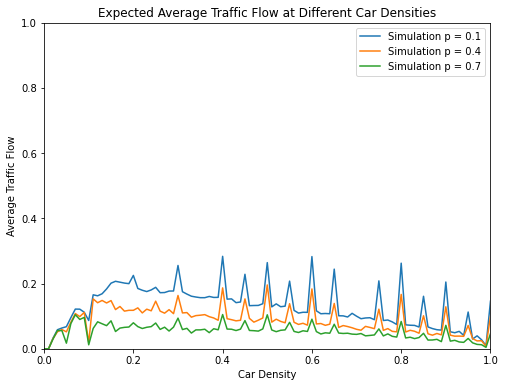

In [35]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    road_len = 50
    max_speed = 5
    prob_slow = [0.1,0.4,0.7]
    lanes_no = 2
    traffic_param = [20, 40]
    car_densities = np.linspace(0, 1, 101)

    trials = 10 # Number of times to repeat the simulation
    sim_flow_results = {} # The results of average flow 

    for prob_slow in prob_slow:
        
        sim_flow_results[prob_slow] = []
        
        for density in car_densities:
            
            flows = []
            
            for trial in range(trials):
                
                blocks = IntersectionSimulation({"Polk" :
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed,
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Union" :
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed, 
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Green" : 
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed,
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Larkin" :
                                                 StreetSimulation(road_length = road_len, 
                                                        car_density = density, 
                                                        max_speed = max_speed, 
                                                        prob_slow = prob_slow, 
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param)})
                
                blocks.runIntersectionSimulation(100, network = False)
                
                # Record the final average traffic flow
                flows.append(blocks.average_traffic_flow())
                
            sim_flow_results[prob_slow].append(np.mean(flows))

    plt.figure(figsize=(8, 6))
    plt.title('Expected Average Traffic Flow at Different Car Densities')
    plt.xlabel('Car Density')
    plt.ylabel('Average Traffic Flow')
    for p, flow in sim_flow_results.items():
        plt.plot(car_densities, flow, label=f'Simulation p = {p}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

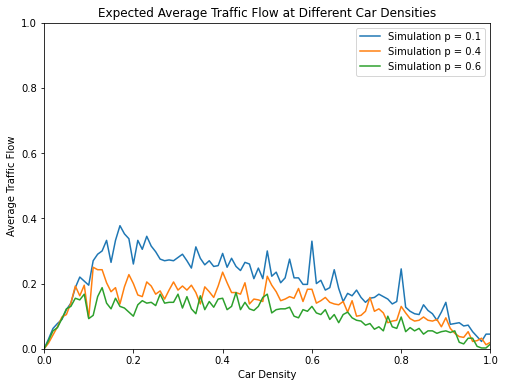

In [31]:
## Peaceful day with spread out traffic signals

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    road_len = 100
    max_speed = 5
    prob_slow = [0.1, 0.4, 0.6]
    lanes_no = 1
    traffic_param = [40, 80]
    car_densities = np.linspace(0, 1, 101)

    trials = 10 # Number of times to repeat the simulation
    sim_flow_results = {} # The results of average flow 

    for prob_slow in prob_slow:
        
        sim_flow_results[prob_slow] = []
        
        for density in car_densities:
            
            flows = []
            
            for trial in range(trials):
                
                blocks = IntersectionSimulation({"Polk" :
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed,
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Union" :
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed, 
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Green" : 
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed,
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Larkin" :
                                                 StreetSimulation(road_length = road_len, 
                                                        car_density = density, 
                                                        max_speed = max_speed, 
                                                        prob_slow = prob_slow, 
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param)})
                
                blocks.runIntersectionSimulation(100, network = False)
                
                # Record the final average traffic flow
                flows.append(blocks.average_traffic_flow())
                
            sim_flow_results[prob_slow].append(np.mean(flows))

    plt.figure(figsize=(8, 6))
    plt.title('Expected Average Traffic Flow at Different Car Densities')
    plt.xlabel('Car Density')
    plt.ylabel('Average Traffic Flow')
    for p, flow in sim_flow_results.items():
        plt.plot(car_densities, flow, label=f'Simulation p = {p}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

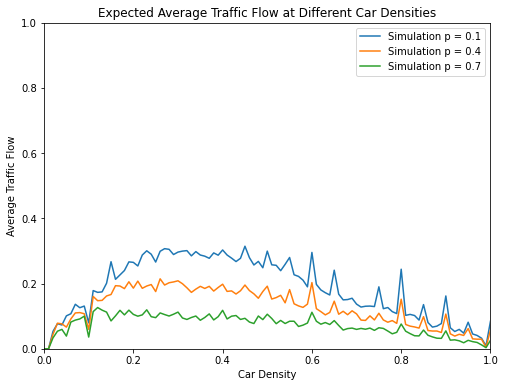

In [34]:
## Strong Congestion

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    road_len = 50
    max_speed = 3
    prob_slow = [0.1, 0.4, 0.7]
    lanes_no = 1
    traffic_param = [10, 20]
    car_densities = np.linspace(0, 1, 101)

    trials = 10 # Number of times to repeat the simulation
    sim_flow_results = {} # The results of average flow 

    for prob_slow in prob_slow:
        
        sim_flow_results[prob_slow] = []
        
        for density in car_densities:
            
            flows = []
            
            for trial in range(trials):
                
                blocks = IntersectionSimulation({"Polk" :
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed,
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Union" :
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed, 
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Green" : 
                                                 StreetSimulation(road_length = road_len,
                                                        car_density = density,
                                                        max_speed = max_speed,
                                                        prob_slow = prob_slow,
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param),
                                                 "Larkin" :
                                                 StreetSimulation(road_length = road_len, 
                                                        car_density = density, 
                                                        max_speed = max_speed, 
                                                        prob_slow = prob_slow, 
                                                        lanes = lanes_no,
                                                        traffic_lights_positions = traffic_param)})
                
                blocks.runIntersectionSimulation(100, network = False)
                
                # Record the final average traffic flow
                flows.append(blocks.average_traffic_flow())
                
            sim_flow_results[prob_slow].append(np.mean(flows))

    plt.figure(figsize=(8, 6))
    plt.title('Expected Average Traffic Flow at Different Car Densities')
    plt.xlabel('Car Density')
    plt.ylabel('Average Traffic Flow')
    for p, flow in sim_flow_results.items():
        plt.plot(car_densities, flow, label=f'Simulation p = {p}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

# MFA

In [14]:
# Code adapted from class session

def meanFieldApproximation(v, density, p_slow):
    v_max = len(v) - 1
    new_v = [0] * len(v)  # The updated speed probability vector
    
    # Establishing probabilities for car behavior in model
    car_prob = [density] * (v_max + 1)
    car_prob = [None] + [(1 - density) ** (distance - 1) * density for distance in range(1, v_max + 1)]
    car_prob.append(1 - np.sum(car_prob[1:]))
    
    for v_from in range(v_max + 1):
        
        # Assign the current speed of car
        speed = v_from
        
        # Determine a car to accelerate when speed is less than max
        if speed < v_max:
            speed += 1
        
        # Given the distance between cars, determine if stopping is necessary
        for distance in range(1, speed + 1):
            
            # Determine the probability of car at a given distance 
            car_at_distance = car_prob[distance]
            
            if distance > 1:
                new_v[distance - 1] += v[v_from] * car_at_distance * (1 - p_slow)
                new_v[distance - 2] += v[v_from] * car_at_distance * p_slow
                
            else:
                new_v[distance - 1] += v[v_from] * car_at_distance
        
        no_cars = 1 - np.sum(car_prob[1 : speed + 1])
        new_v[speed] += v[v_from] * no_cars * (1 - p_slow)
        new_v[speed-1] += v[v_from] * no_cars * p_slow
        
    return new_v

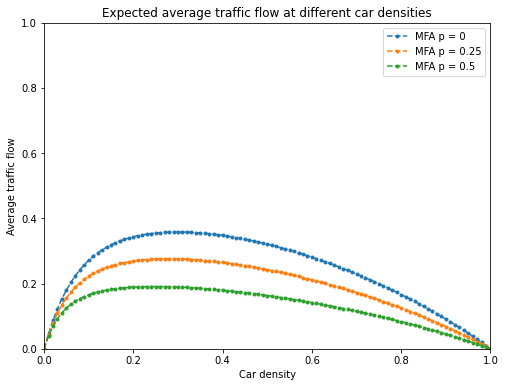

In [15]:

def average_speed(v):
    return np.sum(np.array(v) * np.arange(len(v)))

def average_flow(v, density):
    return density * average_speed(v)

max_speed = 5
p_slows = [0, 0.25, 0.5]
car_densities = np.linspace(0, 1, 101)

# Mapping results for average traffic flow at different densities
mfa_flow_results = {}  

for p_slow in p_slows:
    mfa_flow_results[p_slow] = []
    
    for density in car_densities:
        # Assumes a uniform distribution
        v = [1 / (max_speed + 1)] * (max_speed + 1)
        
        # Sanity check with assert statement
        assert abs(sum(v) - 1) < 1e-6  
        
        # Runs approximation until convergence
        for i in range(100):  
            v = meanFieldApproximation(v, density, p_slow)
            
            # Sanity check
            assert abs(sum(v) - 1) < 1e-6  
            
        # Appends results of approximation
        mfa_flow_results[p_slow].append(average_flow(v, density))

plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')

for p, flow in sim_flow_results.items():
    plt.plot(car_densities, mfa_flow_results[p], marker = '.', linestyle = '--', label = f'MFA p = {p}')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()